## Random tests for coef

In [4]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [62]:
p = 600
n = 300
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [63]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[-0.19962958]
 [-0.37186517]
 [-0.20171144]
 [ 0.3839525 ]
 [ 0.28456818]]
[[ 0.82356385]
 [ 0.39110083]
 [ 0.27774159]
 [ 0.39934474]
 [-1.42959629]]


---------------------------

## Bias and Variance of single bmp

In [5]:
test_num = 1000
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
fit_coef_single_mat = np.concatenate(fit_coef_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
true_coef_vec.shape

(600, 1)

In [16]:
def BIC_objective(Lambda, X, y, coefficient_lst):
    """
    Args:
    beta (numpy.ndarray): Coefficients
    X (numpy.ndarray): Input data
    y (numpy.ndarray): Output data
    lambda_ (float): Regularization parameter
    weights (numpy.ndarray): Weights of the betas

    Returns:
    float: Objective function value
    """
    coefficient_matrix = np.vstack(bmp_model_single.coefficients_lst).T
    aggregated_coefficients = coefficient_matrix @ Lambda
    penalty = 2 * np.sqrt(2) * np.sqrt(np.log(coefficient_matrix.shape[1]*X.shape[0])/X.shape[0])*np.linalg.norm(aggregated_coefficients, ord=1)
    return np.mean((y - X @ aggregated_coefficients)**2) + penalty

In [7]:
bmp_model_single = BMP(**{
    'N_bag': 20,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
})

In [9]:
bmp_model_single.fit(train_dictionary, train_perturbed_signal)

In [15]:
np.vstack(bmp_model_single.coefficients_lst).T.shape

(600, 20)

In [18]:
BIC_objective(np.ones(20),train_dictionary,train_perturbed_signal,bmp_model_single.coefficients_lst)

266.72752051072484

In [45]:
true_indices

array([135, 521, 114, 259, 374, 321, 224,  19, 416, 357, 157, 431, 371,
        78,  47, 129, 326, 168, 291,  86])

In [82]:
true_coefficients

array([[ 0.01062506],
       [ 1.29804996],
       [ 0.06613403],
       [ 0.94804568],
       [-0.7154875 ],
       [ 2.07653639],
       [ 0.07114403],
       [ 0.42360513],
       [ 0.63339999],
       [-1.58503907],
       [ 0.35807592],
       [-0.62005885],
       [-1.09189176],
       [-1.041422  ],
       [ 0.88221368],
       [-0.78961773],
       [-2.05852574],
       [-1.21351023],
       [-0.2027221 ],
       [ 0.41900617]])

In [69]:
fit_coef_single_mat.shape

(600, 1000)

In [70]:
fit_coef_single_mean = np.mean(fit_coef_single_mat, axis=1)
fit_coef_single_mean.shape

(600,)

In [13]:
fit_coef_single_mean[321]

1.4161686817990795

In [18]:
fit_coef_single_mean.shape

(600,)

In [15]:
fit_coef_single_bias_19 = fit_coef_single_bias[321]
print(fit_coef_single_bias_19)

0.3296588510264082


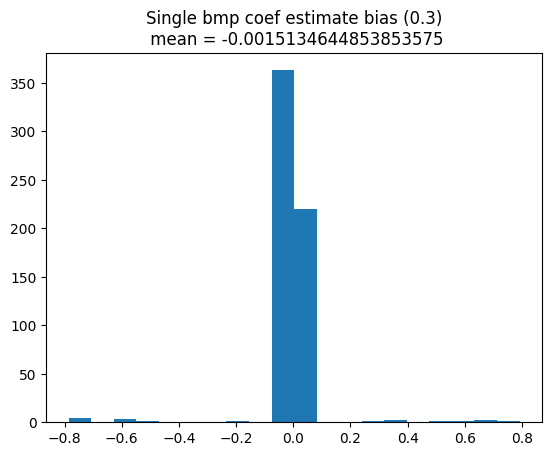

In [88]:
plt.hist(fit_coef_single_bias, bins=20)
fit_coef_single_bias_mean = np.mean(fit_coef_single_bias)
plt.title(f"Single bmp coef estimate bias (0.3)\n mean = {fit_coef_single_bias_mean}")
plt.show()

Variance of single mp (0.3)

In [31]:
fit_coef_single_mat.shape
fit_coef_single_var.shape

(600,)

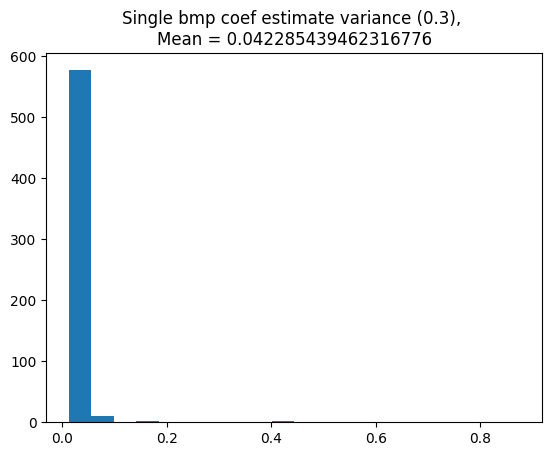

In [90]:
plt.hist(fit_coef_single_var, bins=20)
fit_coef_single_var_mean = np.mean(fit_coef_single_var)
plt.title("Single bmp coef estimate variance (0.3), \nMean = " + str(fit_coef_single_var_mean))
plt.show()

idx 19 single variance

In [91]:
fit_coef_single_var_19 = fit_coef_single_var[321]
print(fit_coef_single_var_19)

0.8427663632432626


Do the same for 0.9, 0.9

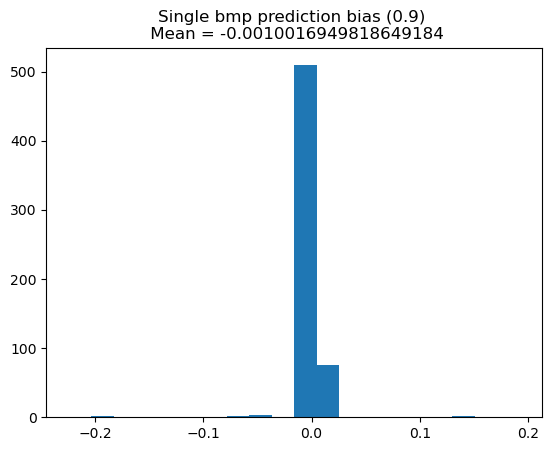

In [22]:
test_num = 500
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
    
fit_coef_single_mat_09 = np.concatenate(fit_coef_lst, axis = 1)
fit_coef_single_mean_09 = np.mean(fit_coef_single_mat_09, axis=1)
fit_coef_single_bias_09 = fit_coef_single_mean_09.ravel() - true_coef_vec.ravel()

plt.hist(fit_coef_single_bias_09, bins=20)

fit_coef_single_bias_09_mean = np.mean(fit_coef_single_bias_09)

plt.title(f"Single bmp prediction bias (0.9) \n Mean = {fit_coef_single_bias_09_mean}")
plt.show()

idx 19 bias (0.9)

In [129]:
fit_coef_single_bias_09_19 = fit_coef_single_bias_09[321]
print(fit_coef_single_bias_09_19)

-0.03392278246755431


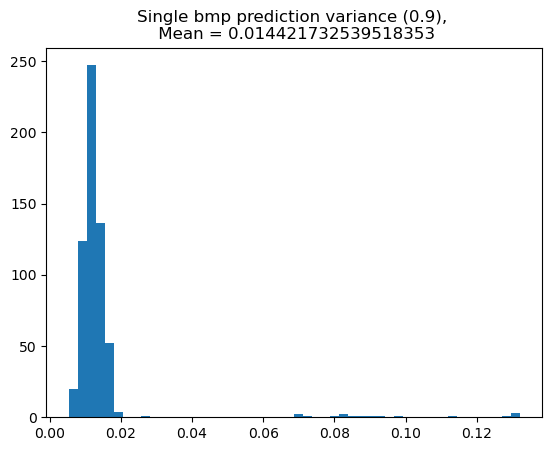

In [19]:
fit_coef_single_var_09 = np.var(fit_coef_single_mat_09, axis=1)
plt.hist(fit_coef_single_var_09, bins=50)
fit_coef_single_var_09_mean = np.mean(fit_coef_single_var_09)
plt.title("Single bmp prediction variance (0.9), \n Mean = " + str(fit_coef_single_var_09_mean))
plt.show()

idx 19 variance (0.9)



In [130]:
fit_coef_single_var_09_19 = fit_coef_single_var_09[321]
print(fit_coef_single_var_09_19)

0.09896969037159375


----------------------

## MSE

In [39]:
test_num = 500
N_bag = 200

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = data_seed + i
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients

In [40]:
fit_coef_ensemble_mat.shape

(600, 500)

In [41]:
true_coef_vec.shape

(600, 1)

In [42]:
ensemble_coef_mse_multitrial = (fit_coef_ensemble_mat - true_coef_vec) ** 2
ensemble_coef_mse_multitrial.shape

(600, 500)

0.20626372884725006


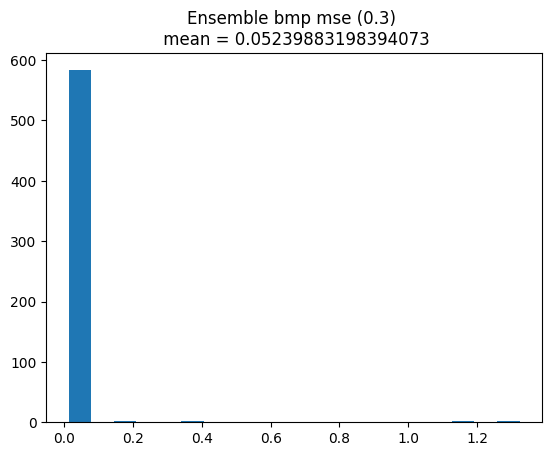

In [43]:
ensemble_coef_mse_multitrial_exp = np.mean(ensemble_coef_mse_multitrial, axis = 1)
ensemble_coef_mse_multitrial_exp.shape

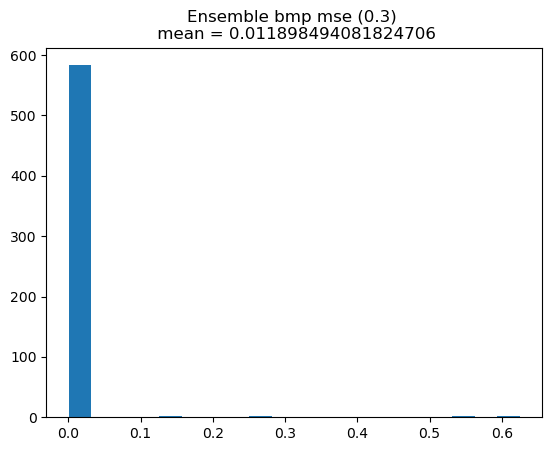

In [95]:
plt.hist(ensemble_coef_mse_multitrial_exp, bins = 20)
ensemble_coef_mse_multitrial_exp_mean = np.mean(ensemble_coef_mse_multitrial_exp)
plt.title('Ensemble bmp mse (0.3) \n mean = ' + str(ensemble_coef_mse_multitrial_exp_mean))
plt.show()

idx 19 mse mean 

In [134]:
ensemble_coef_mse_multitrial_exp_19 = ensemble_coef_mse_multitrial_exp[321]
print(ensemble_coef_mse_multitrial_exp_19)

0.5248320391035866


Do the same for 0.9, 0.9

In [31]:
test_num = 500
N_bag = 200

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = data_seed + i
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat_09 = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec_09 = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec_09[true_indices] = true_coefficients

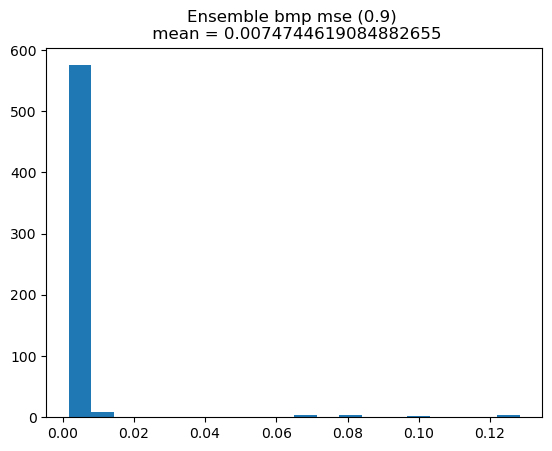

In [32]:
ensemble_coef_mse_multitrial_09 = (fit_coef_ensemble_mat_09 - true_coef_vec_09) ** 2
ensemble_coef_mse_multitrial_09_exp = np.mean(ensemble_coef_mse_multitrial_09, axis = 1)

plt.hist(ensemble_coef_mse_multitrial_09_exp, bins = 20)

ensemble_coef_mse_multitrial_09_exp_mean = np.mean(ensemble_coef_mse_multitrial_09_exp)
plt.title('Ensemble bmp mse (0.9) \n mean = ' + str(ensemble_coef_mse_multitrial_09_exp_mean))
plt.show()

idx 19 mse (0.9)

In [135]:
ensemble_coef_mse_multitrial_09_exp_19 = ensemble_coef_mse_multitrial_09_exp[321]
print(ensemble_coef_mse_multitrial_09_exp_19)

0.08255343085584857


--------------

## Correlation

In [144]:
test_num = 500
N_bag = 200

model_params_single = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j * 1000 
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst.append(fit_coef_bag)

In [145]:
len(fit_coef_bag_multitiral_lst[0][0])

600

In [146]:
stack_lst = []
for i in range(len(fit_coef_bag_multitiral_lst)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst[i], axis=1)
    stack_lst.append(tmp)

d3 = np.stack(stack_lst)
d3.shape

(500, 600, 200)

idx 19 correlation

In [147]:
slice_19 = d3[:, 321, :]
slice_19.shape

(500, 200)

In [148]:
np.mean(slice_19)

1.453007525663218

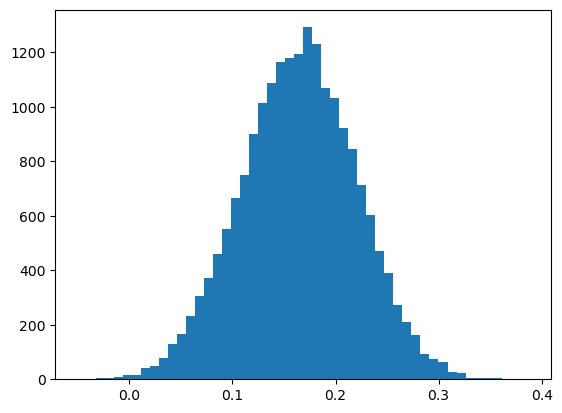

In [149]:
corr_19 = np.corrcoef(slice_19, rowvar=False)
upper_corr_19 = corr_19[np.triu_indices(corr_19.shape[0], k=1)]
plt.hist(upper_corr_19, bins=50)
plt.show()

In [150]:
# mean corr for idx 19
corr_19_mean = np.mean(upper_corr_19)
print(corr_19_mean)

0.16461821749880232


Overlap all coefs

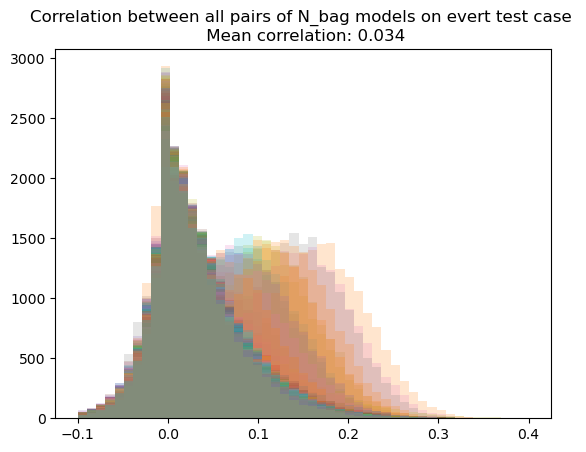

In [151]:
bins = np.linspace(-0.1, 0.4, 50)
all_corr = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()


Check the corraltion for 0.9, 0.9

In [124]:
test_num = 500
N_bag = 200

model_params_single = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst_09 = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst_09.append(fit_coef_bag)
    
stack_lst_09 = []
for i in range(len(fit_coef_bag_multitiral_lst_09)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst_09[i], axis=1)
    stack_lst_09.append(tmp)

d3_09 = np.stack(stack_lst_09)
d3_09.shape

(500, 600, 200)

idx 19 corr (0.9)

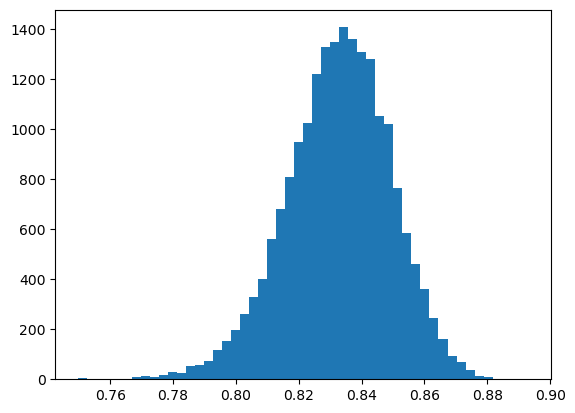

In [126]:
slice_19_09 = d3_09[:, 321, :]
corr_19_09 = np.corrcoef(slice_19_09, rowvar=False)
upper_corr_19_09 = corr_19_09[np.triu_indices(corr_19_09.shape[0], k=1)]
plt.hist(upper_corr_19_09, bins=50)
plt.show()

In [127]:
corr_19_09_mean = np.mean(upper_corr_19_09)
print(corr_19_09_mean)

0.8326379227700079


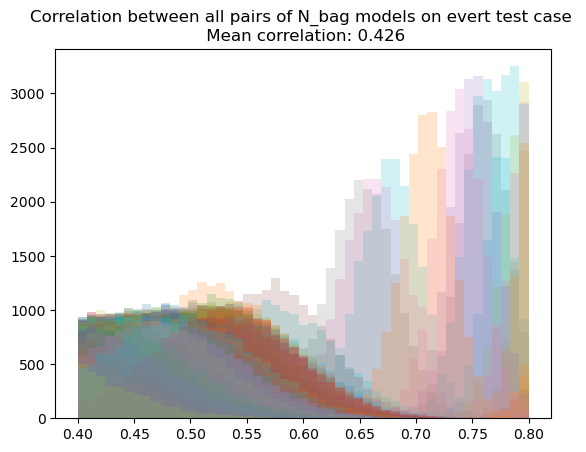

In [128]:
bins = np.linspace(0.4, 0.8, 50)
all_corr = []

for i in range(d3_09.shape[1]):
    slice_tmp = d3_09[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()

# Sparsity Recovery Rate

In [100]:
model_params_single = {
    'N_bag': N_bag,
    'K': 40,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.4
data_seed = 2


test_num = 20
N_bag_list = [10,50,100,200,300]
# N_bag_list = [10,20]

final_coef_recovery_rates = []
final_total_recover_rates = []


for N_bag in N_bag_list:
    model_params_single["N_bag"] = N_bag
    coef_recovery_rates = []
    total_recover_rates = []
    fit_coef_lst = []
    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
    test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()
    true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
    true_coef_vec[true_indices] = true_coefficients
    true_sparsity = (true_coef_vec!=0).astype(int).ravel()
    true_sparsity_matrix = np.outer(true_sparsity,np.ones(N_bag))
    for i in range(test_num):
        _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
        model_params_single['random_seed'] = data_seed + i
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        coef_lst_temp = np.vstack(bmp_model_single.coefficients_lst).T
        coef_sparsity_temp = (coef_lst_temp!=0).astype(int)
        count_temp = np.multiply(coef_sparsity_temp,true_sparsity_matrix)
        coef_recovery_rates.append(count_temp.mean(axis=1))
        total_recover_rates.append(count_temp.sum(axis=0)/true_indices.shape[0])

    final_coef_recovery_rates.append(np.mean(coef_recovery_rates,axis=0))
    final_total_recover_rates.append(np.mean(total_recover_rates))



Text(0.5, 1.0, 'Total recover rate for different N_bag at Noise = 0.4')

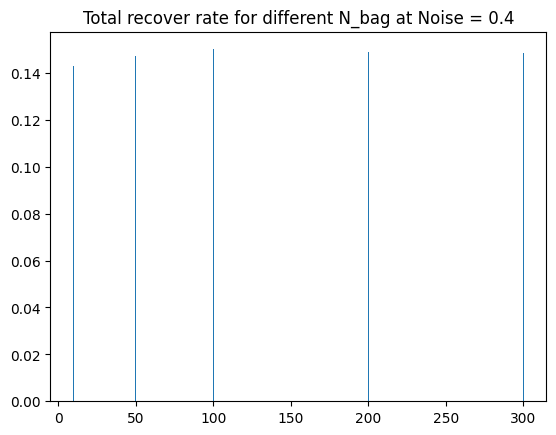

In [101]:
plt.bar(N_bag_list, final_total_recover_rates)
plt.title(f'Total recover rate for different N_bag at Noise = {noise_level}')

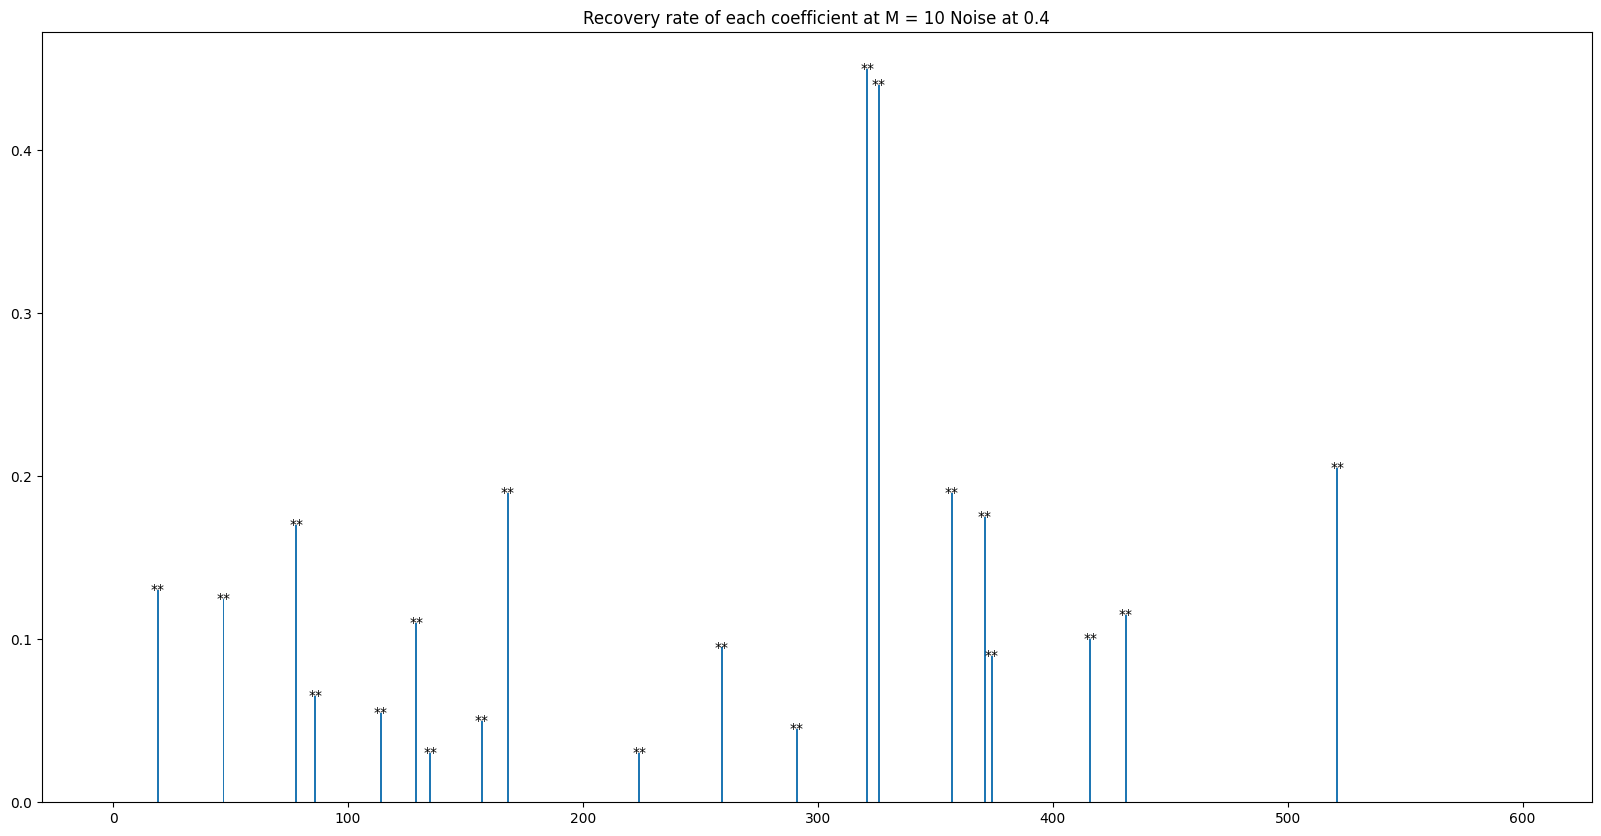

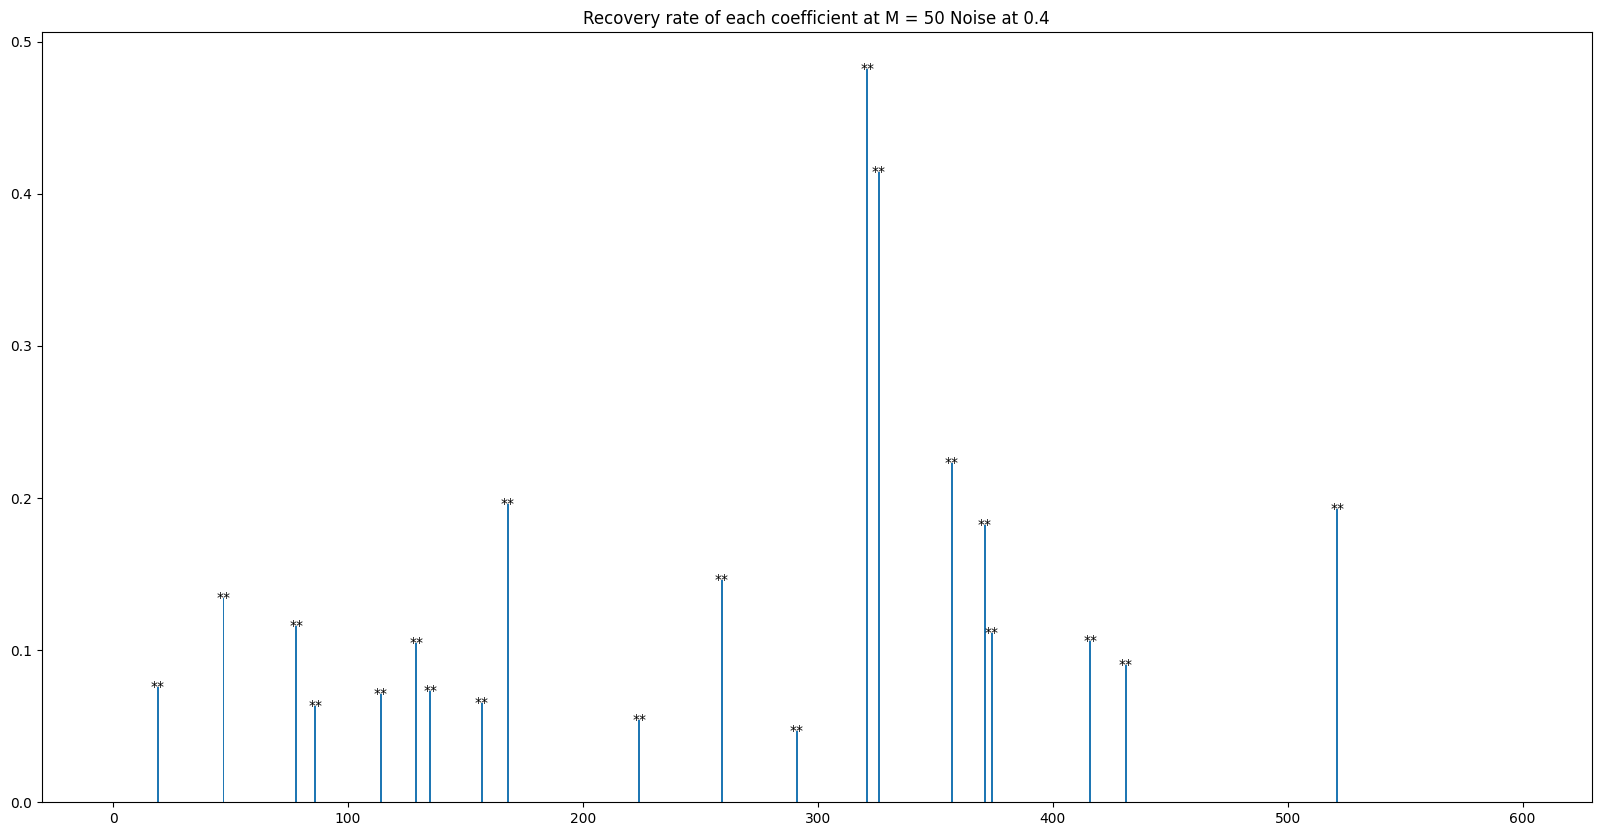

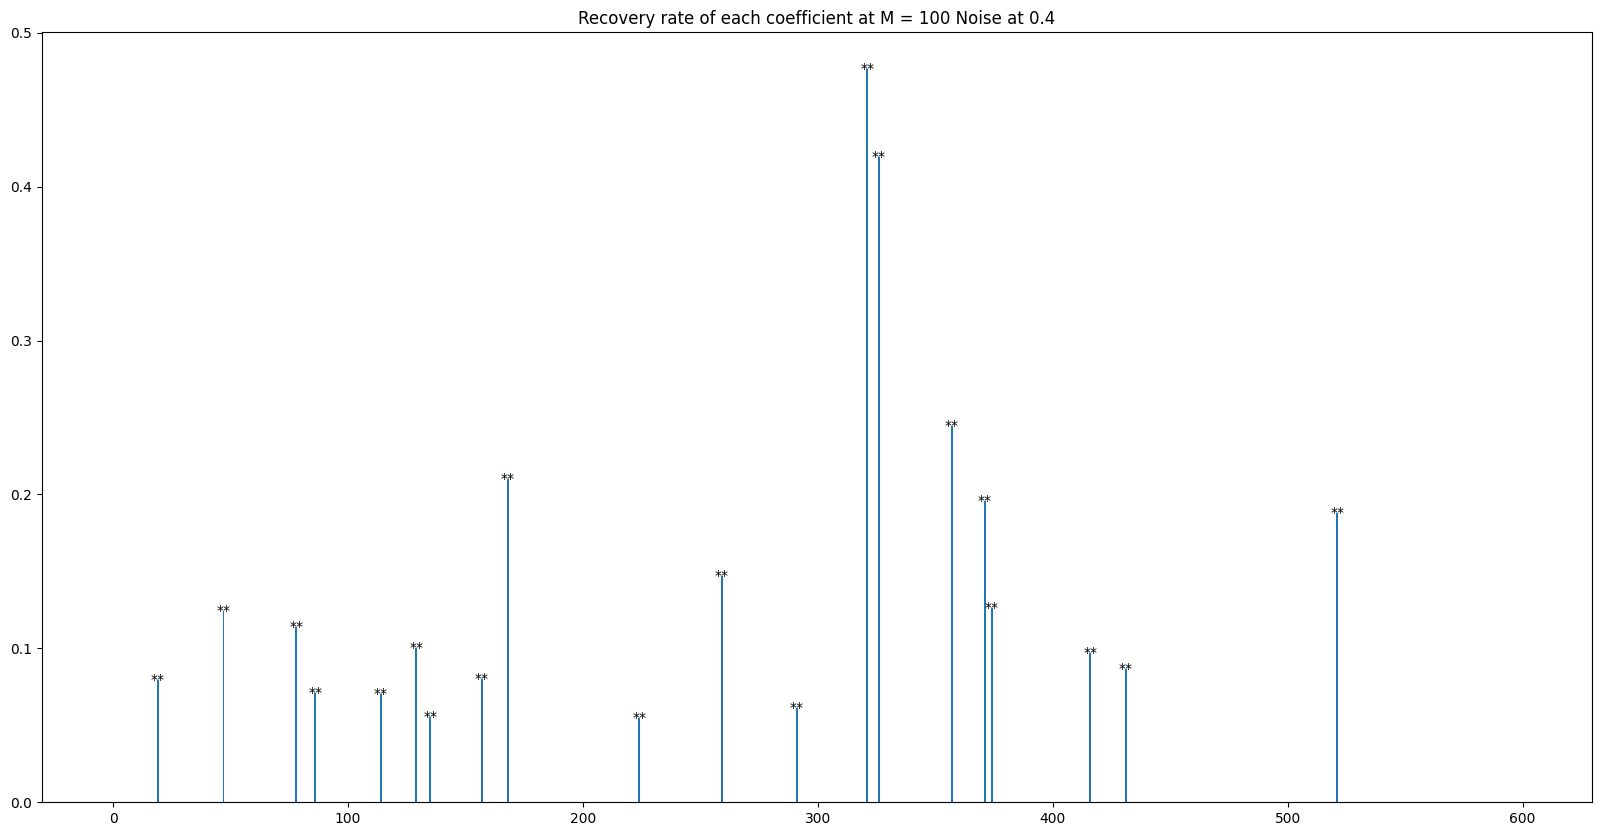

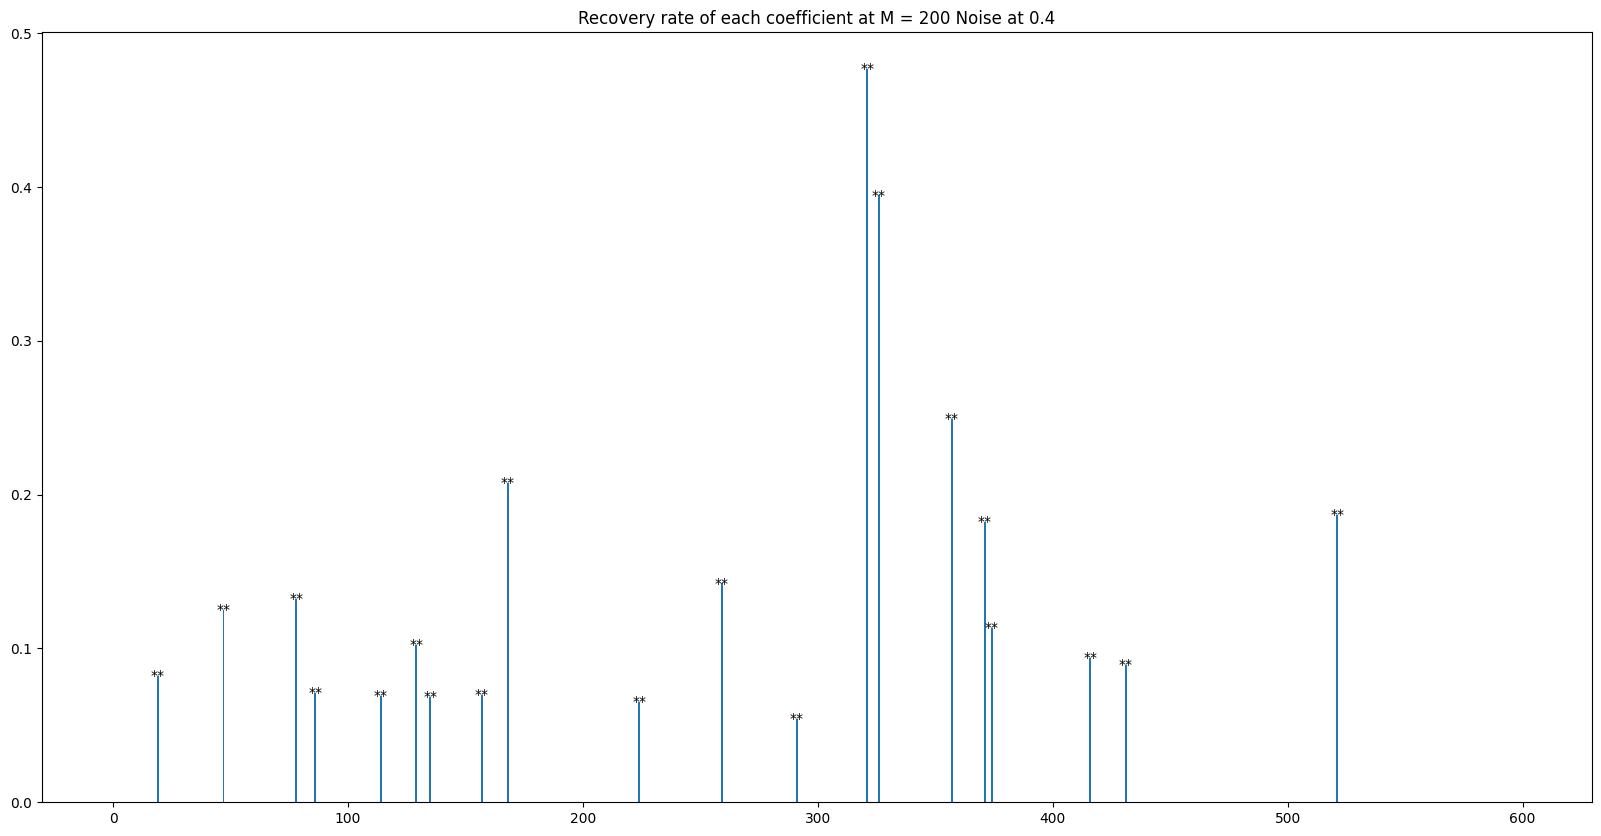

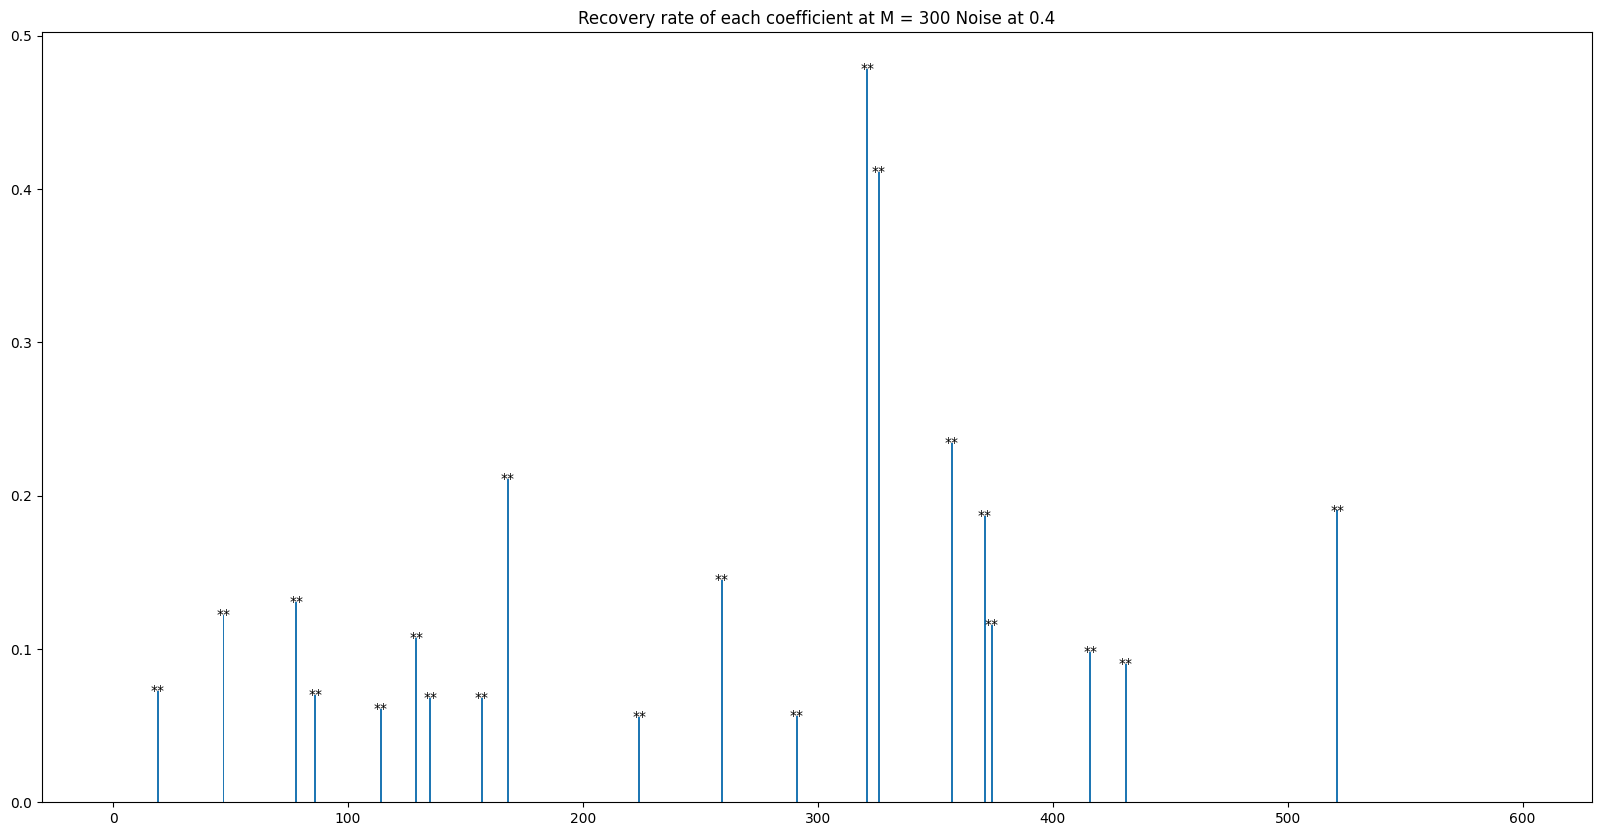

In [104]:
for recover_rate_index in range(len(N_bag_list)):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    bars = ax.bar(np.arange(p), height=final_coef_recovery_rates[recover_rate_index])
    ax.set_title(f'Recovery rate of each coefficient at M = {N_bag_list[recover_rate_index]} Noise at {noise_level}')
    
    for sparse_index in range(true_indices.shape[0]):
        # Here, it's better to use the top of the bar's height rather than the recover_rates array for positioning the text
        bar_height = bars[true_indices[sparse_index]].get_height()
        ax.text(x=true_indices[sparse_index], y=bar_height, s='**', ha='center', va='center')
    
    plt.show()

-----------------------

0.3 bias-variance trade-off

In [98]:
fit_coef_single_bias_19_sq = fit_coef_single_bias_19 * fit_coef_single_bias_19
fit_coef_single_bias_19_sq

0.43608550690491166

In [99]:
fit_coef_single_var_19

0.8427663632432626

In [100]:
ensemble_coef_mse_multitrial_exp_19

0.5248320391035866

In [104]:
(ensemble_coef_mse_multitrial_exp_19 - fit_coef_single_bias_19_sq) / fit_coef_single_var_19

0.10530383753944202

In [108]:
corr_19_mean

0.16335093201523518

0.9 bias-variance trade-off

In [131]:
fit_coef_single_bias_09_19_sq = fit_coef_single_bias_09_19 * fit_coef_single_bias_09_19
fit_coef_single_bias_09_19_sq

0.0011507551703410102

In [132]:
fit_coef_single_var_09_19

0.09896969037159375

In [136]:
ensemble_coef_mse_multitrial_09_exp_19

0.08255343085584857

In [137]:
(ensemble_coef_mse_multitrial_09_exp_19 - fit_coef_single_bias_09_19_sq)

0.08140267568550756

In [138]:
(ensemble_coef_mse_multitrial_09_exp_19 - fit_coef_single_bias_09_19_sq) / fit_coef_single_var_09_19

0.8225010645165333

In [139]:
corr_19_09_mean

0.8326379227700079

-----------------

All below are not related

In [ ]:
test_num = 500
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 2

y_pred_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    y_pred_single = bmp_model_single.predict(test_dictionary)
    y_pred_lst.append(y_pred_single)
    
y_pred_single_mat = np.concatenate(y_pred_lst, axis = 1)

In [144]:
test_num = 50

# variance because of bagging

def cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, test_num):
    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
    test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()
    coef = np.zeros((test_dictionary.shape[1], 1))
    coef[true_indices] = true_coefficients
    coef = coef.ravel()
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + 100)
    y_pred_lst = []
    y_pred_re_lst = []
    coef_lst = []
    coef_re_lst = []
    for test_i in range(test_num):
        _, train_dictionary_resample, _, _, train_perturbed_signal_resample = Data_Geneartor.keep_coef_reshuffle(seed = data_seed + test_i)
        model_params['random_seed'] = data_seed + test_i
        bmp_model_single = BMP(**model_params)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        coef_lst.append(bmp_model_single.coefficients.reshape(-1, 1))
        bmp_model2 = BMP(**model_params)
        bmp_model2.fit(train_dictionary_resample, train_perturbed_signal_resample)
        coef_re_lst.append(bmp_model2.coefficients.reshape(-1, 1))
        y_pred_re = bmp_model2.predict(test_dictionary)
        y_pred_re_lst.append(y_pred_re)
        y_pred = bmp_model_single.predict(test_dictionary)
        y_pred_lst.append(y_pred)
    y_pred_mat = np.concatenate(y_pred_lst, axis = 1)
    y_pred_re_mat = np.concatenate(y_pred_re_lst, axis = 1)
    coef_mat = np.concatenate(coef_lst, axis = 1)
    coef_re_mat = np.concatenate(coef_re_lst, axis = 1)
    
    return y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices

In [166]:
model_params = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 2

y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices = cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, 1000)

In [167]:
y_pred_mat.shape

(600, 1000)

In [168]:
en_pred = np.mean(y_pred_mat, axis=1).reshape(-1, 1)

In [169]:
test_true_signal.shape

(600, 1)

In [170]:
mse = np.mean((test_true_signal - en_pred)**2)
mse

0.004568843089159411

In [171]:
test_err = np.mean((test_perturbed_signal - en_pred)**2)
test_err

0.044543106404829225

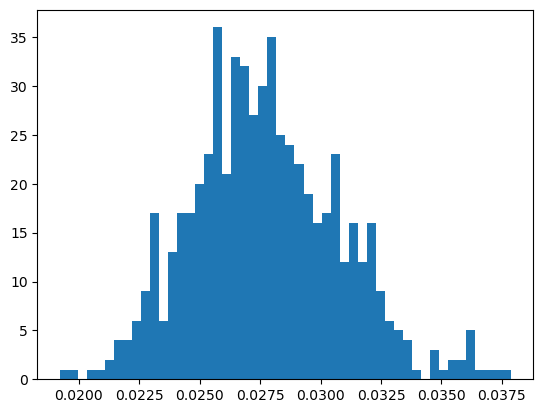

In [172]:
pred_var = np.var(y_pred_mat, axis=1)
plt.hist(pred_var, bins=50)
plt.show()

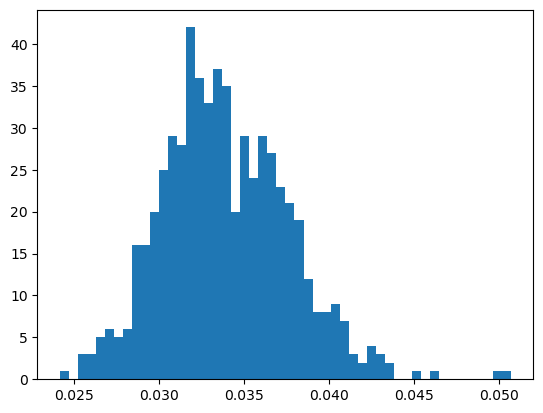

In [174]:
pred_re_var = np.var(y_pred_re_mat, axis=1)
plt.hist(pred_re_var, bins=50)
plt.show()

In [175]:
np.mean(pred_var)

0.02774428124886441

In [176]:
pred_corr = np.corrcoef(y_pred_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.37417507897739277

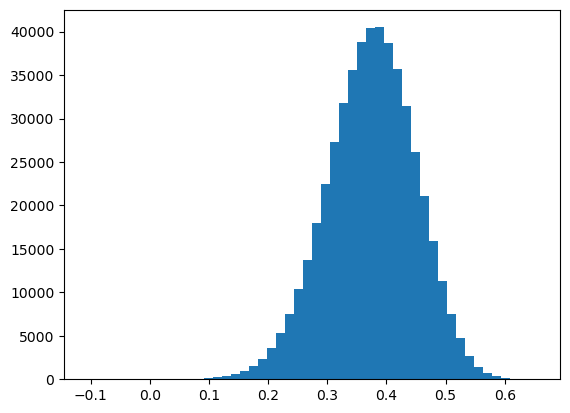

In [177]:
plt.hist(pred_corr_utri, bins = 50)
plt.show()

In [178]:
np.mean(pred_re_var)

0.03393223925904527

In [179]:
pred_corr = np.corrcoef(y_pred_re_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.2573670606428

In [180]:
mse / np.mean(pred_var)

0.16467693101065348

coef

In [181]:
coef_mat.shape

(300, 1000)

In [182]:
true_indice_coef = coef_mat[true_indices, :]

In [183]:
coef_avg = np.mean(coef_mat, axis=1)
coef_avg.shape

(300,)

In [184]:
coef_var = np.var(coef_mat, axis=1)
np.mean(coef_var)

0.055691895953478315

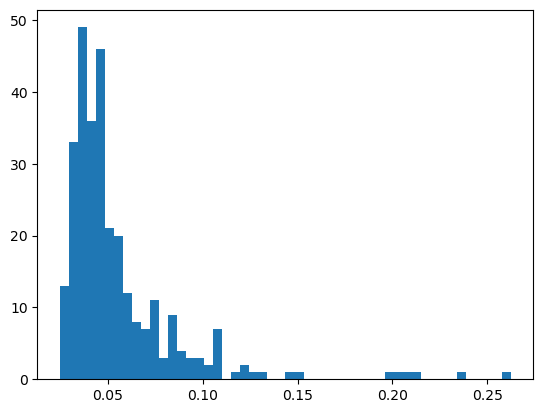

In [185]:
plt.hist(coef_var, bins=50)
plt.show()

(array([2., 3., 0., 1., 0., 1., 2., 4., 0., 1., 0., 0., 0., 0., 2., 2., 0.,
        1., 0., 1.]),
 array([0.04130872, 0.05236231, 0.06341591, 0.07446951, 0.08552311,
        0.0965767 , 0.1076303 , 0.1186839 , 0.1297375 , 0.14079109,
        0.15184469, 0.16289829, 0.17395189, 0.18500548, 0.19605908,
        0.20711268, 0.21816628, 0.22921987, 0.24027347, 0.25132707,
        0.26238067]),
 <BarContainer object of 20 artists>)

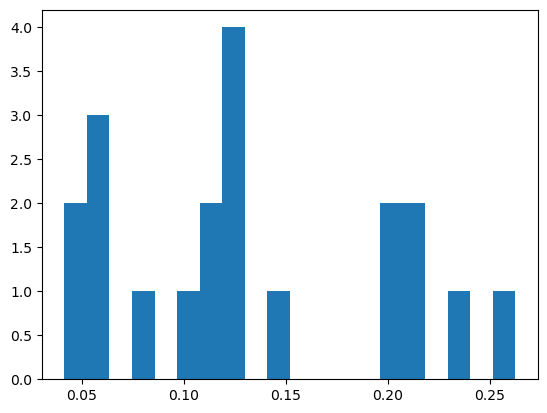

In [198]:
true_coef_var = np.mean(coef_var[true_indices])
true_coef_var
plt.hist(coef_var[true_indices], bins=20)

In [190]:
true_coef_mse = np.mean((coef_avg[true_indices] - coef[true_indices])**2)
true_coef_mse

0.05786680788949945

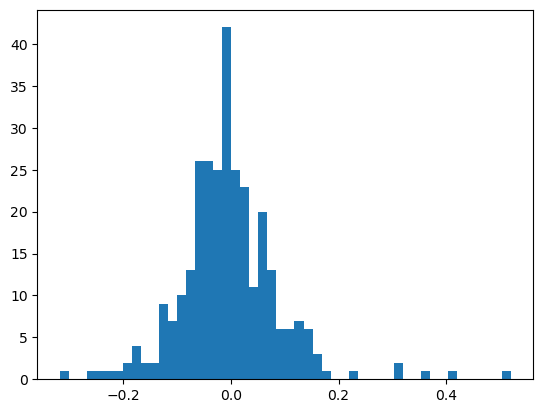

In [191]:
plt.hist(coef_avg - coef, bins = 50)
plt.show()

In [194]:
true_coef_corr = np.corrcoef(coef_mat[true_indices, :], rowvar=False)
true_coef_corr_utri = true_coef_corr[np.triu_indices(true_coef_corr.shape[0], k=1)]
np.mean(true_coef_corr_utri)

0.7690556470919081

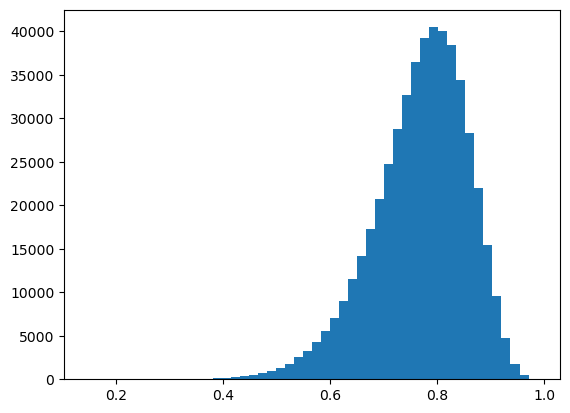

In [197]:
plt.hist(true_coef_corr_utri,  bins=50)
plt.show()

In [195]:
true_coef_mse / true_coef_var

0.438342836166106

In [193]:
coef_mat.shape

(300, 1000)

In [142]:
coef_mat.shape

(300, 500)

In [136]:
coef_corr = np.corrcoef(coef_mat, rowvar=False)
coef_corr_utri = coef_corr[np.triu_indices(coef_corr.shape[0], k=1)]
np.mean(coef_corr_utri)

0.361988966453134

In [143]:
coef_corr.shape

(500, 500)

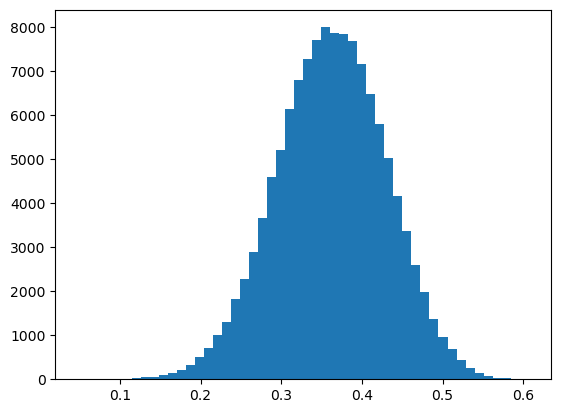

In [140]:
plt.hist(coef_corr_utri, bins = 50)
plt.show()

In [163]:
coef_mse / np.mean(coef_var)

0.15718096309857135